In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize

In [2]:
data=pd.read_csv('data/linear_regression.txt', names=['x', 'y'])
data.head()

,x,y
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


<AxesSubplot:xlabel='x', ylabel='y'>

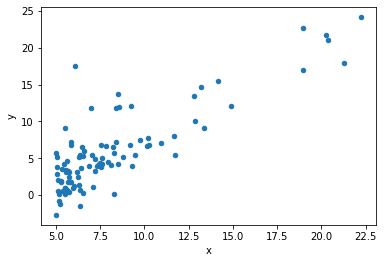

In [3]:
data.plot.scatter(x='x', y='y')

In [4]:
data_np = data.to_numpy()
np.random.shuffle(data_np)
data_np[0:10]

array([[ 5.1077,  2.0576],
       [ 6.1891,  3.1386],
       [ 5.8014,  1.844 ],
       [ 8.5186, 13.662 ],
       [ 6.8825,  3.9115],
       [ 6.4296,  3.6518],
       [ 5.8598,  6.8233],
       [ 5.0702,  5.1337],
       [18.945 , 22.638 ],
       [ 7.4764,  4.3483]])

In [5]:
def extract(data_np, start, end):
    X = None
    y = None
    n = data_np.shape[1]
    for i in range(start, end):
        if X is None:
            X = data_np[i, 0:(n-1)].reshape(1, n - 1)                      
            y = data_np[i, n-1].reshape(1, 1)
        else:
            X = np.concatenate((X, data_np[i, 0:(n-1)].reshape(1, n - 1)))  
            y = np.concatenate((y, data_np[i, n-1].reshape(1, 1)))
    return X, y

def expand(X, p):
    p = p + 1
    m = X.shape[0]
    n = X.shape[1]
    result = np.concatenate((
        np.ones((m, 1)),
        X
    ), axis=1)
    
    pv = [0] * n
    while True:
        r = 1
        sumof = 0
        for i in range(0, n):
            pv[i] = pv[i] + r
            r = pv[i] // p
            pv[i] = pv[i] % p
            sumof = sumof + pv[i]
        if r > 0:
            break
        if sumof < 2:
            continue
        toadd = None
        for i in range(0, n):
            if pv[i] < 1:
                continue
            temp = np.power(X[:, i], pv[i]).reshape(m, 1)
            if toadd is None:
                toadd = temp
            else:
                toadd = toadd + temp
        result = np.concatenate((
            result,
            toadd
        ), axis=1)
    return result
    

def cost_fn(theta, X, y, lamb):
    # Note: np.multiply performs element-wise multiplication instead of matrix multiplication
    # Note: np.matmul performs matrix multiplication
    m = X.shape[0]
    n = X.shape[1]
    Theta = theta.reshape(n, 1)
    h = np.matmul(X, Theta)
    result = h - y
    result = np.sum(np.multiply(result, result)) / (2 * m)
    result = result + (lamb / (2 * m)) * (np.sum(np.multiply(Theta, Theta)) - math.pow(Theta[0,0], 2))
    
    return result

def gradient_fn(theta, X, y, lamb):
    m = X.shape[0]
    n = X.shape[1]
    Theta = theta.reshape(n, 1)
    h = np.matmul(X, Theta)
    result = (np.matmul(X.T, (h - y)) / m)
    
    lamb_vector = np.ones((n, 1))
    lamb_vector[0, 0] = 0
    
    result = result + (lamb / m) * np.multiply(lamb_vector, Theta)
    
    return result.reshape(n)

def solve(X, y, lamb):
    n = X.shape[1]
    result = optimize.minimize(
        lambda theta: cost_fn(theta, X, y, lamb),
        jac=lambda theta: gradient_fn(theta, X, y, lamb),
        x0=np.array([0] * n),
        method='BFGS')
    return result.x.reshape(n, 1)

def select_model(data_np, max_p):
    m = data_np.shape[0]
    Xtrain, ytrain = extract(data_np, 0, math.ceil(m*0.6))
    Xcv, ycv = extract(data_np, math.ceil(m*0.6), math.ceil(m*0.8))
    Xtest, ytest = extract(data_np, math.ceil(m*0.8),m)
    df = None
    for p in range(1, max_p):
        Xtrain_ex = expand(Xtrain, p)
        Xcv_ex = expand(Xcv, p)
        theta = solve(Xtrain_ex, ytrain, 0)
        cost = cost_fn(theta, Xcv_ex, ycv, 0)
        if df is None:
            df = pd.DataFrame([[p, cost]])
        else:
            df = df.append(pd.DataFrame([[p, cost]]))
    df.plot.line(x=0, y=1)
        

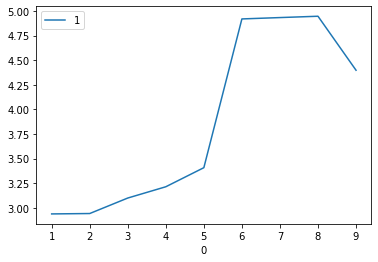

In [6]:
select_model(data_np, 10)

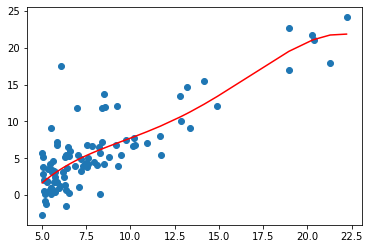

In [7]:
P = 4

def plot_model():
    m = data.shape[0]
    X, y = extract(data_np, 0, m)
    X = expand(X, P)
    n = X.shape[1]
    theta = solve(X, y, 0)
    Xsorted = X[X[:,1].argsort()]
    yhat = np.matmul(Xsorted, theta)

    plt.plot(Xsorted[:,1], yhat, color = 'r')
    plt.scatter(X[:,1], y)
    
plot_model()

In [12]:
def select_lambda(data_np, P, begin, end, step):
    m = data.shape[0]
    Xtrain, ytrain = extract(data_np, 0, math.ceil(m * 0.8))
    Xcv, ycv = extract(data_np, math.ceil(m * 0.8), m)
    Xtrain = expand(Xtrain, P)
    Xcv = expand(Xcv, P)
    
    lamb = begin
    df = None
    while lamb < end:
        theta = solve(Xtrain, ytrain, lamb)
        cost = cost_fn(theta, Xcv, ycv, 0)
        if df is None:
            df = pd.DataFrame([[lamb, cost]])
        else:
            df = df.append(pd.DataFrame([[lamb, cost]]))
        lamb = lamb + step
        
    df.plot.line(x=0, y=1)

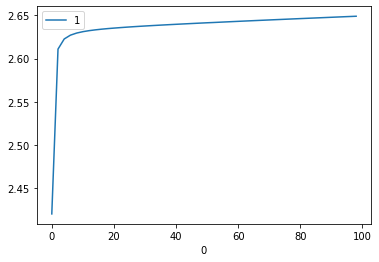

In [13]:
select_lambda(data_np, P, 0, 100, 2)

In [14]:
lamb = 0

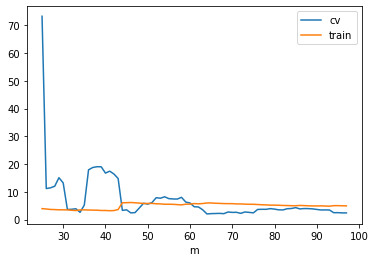

In [24]:
def draw_learning_curve(data_np, P, lamb, start):
    M = data.shape[0]
    m = start
    df_cv = None
    df_train = None
    
    while m <= M:
        Xtrain, ytrain = extract(data_np, 0, math.ceil(m * 0.8))
        Xcv, ycv = extract(data_np, math.ceil(m * 0.8), m)
        Xtrain = expand(Xtrain, P)
        Xcv = expand(Xcv, P)
        
        theta = solve(Xtrain, ytrain, lamb)
        cost_train = cost_fn(theta, Xtrain, ytrain, 0)
        cost_cv = cost_fn(theta, Xcv, ycv, 0)
        
        temp_cv = pd.DataFrame([[m, cost_cv]], columns=['m', 'cv'])
        temp_train = pd.DataFrame([[m, cost_train]], columns=['m', 'train'])
        
        if df_cv is None:
            df_cv = temp_cv
            df_train = temp_train
        else:
            df_cv = df_cv.append(temp_cv)
            df_train = df_train.append(temp_train)
        m = m + 1
            
    ax = df_cv.plot.line(x='m', y='cv')
    df_train.plot.line(x='m', y='train', ax=ax)
    
draw_learning_curve(data_np, P, lamb, 25)